In [ ]:
import numpy as np
import scipy.integrate
import scipy.optimize
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import casadi as ca
import time
import sys
import os

# Add the parent directories to the path to import the dynamics
sys.path.append(os.path.join(os.path.dirname(os.getcwd()), '..', '..'))
sys.path.append(os.path.join(os.path.dirname(os.getcwd()), '..', '..', 'dynamics'))
sys.path.append(os.path.join(os.path.dirname(os.getcwd()), '..', '..', 'convexOPT'))
sys.path.append(os.path.join(os.path.dirname(os.getcwd()), '..', '..', 'vanilla_dynamics'))

from dynamics.CR3BPDynamics import CR3BPDynamics
from vanilla_dynamics.VanillaCR3BPDynamics import VanillaCR3BPDynamics
from convexOPT.SCVX import CVXProgram

#%% Parameters and Initial Data
LU = 3.84405000e5  # km
LUm = LU * 1e3     # m
TU = 3.75676967e5  # s

mu_val = 1.21506683e-2  # CR3BP parameter mu
g0 = 9.80665          # m/s^2

m0 = 1000             # kg

I_sp = 3000 
T_max = 0.01 / LUm * (TU**2)

c_val = I_sp * g0 / LUm * TU

# Initial and final conditions (r and v only)
r_i = np.array([1.017622294477337, 0, -0.06992934709718])
v_i = np.array([0, 0.48658120798033794, 0])
r_f = np.array([1.04529515e+00, 1.49886124e-05, -7.55315229e-02])
v_f = np.array([-5.68281162e-05, 3.87703593e-01, -1.09994997e-04])

t_i = 2.90774977
t_f = 3.139300014901161

#%% Instantiate and Set Up CR3BP Dynamics
# Create instance of the new CR3BP dynamics class
cr3bp_dynamics = CR3BPDynamics()
cr3bp_dynamics.set_params(mu=mu_val, c=c_val)
cr3bp_dynamics.compile()

# Also create vanilla dynamics for uncontrolled propagation
vanilla_cr3bp = VanillaCR3BPDynamics()
vanilla_cr3bp.set_params(mu=mu_val)
vanilla_cr3bp.compile()

# For integrations we use the vanilla dynamics with zero control
zero_control = np.zeros(3)

# Define the ODE function using the compiled vanilla CR3BP dynamics
def ode(t, x):
    # x is a state vector of length 6 (position and velocity only for vanilla)
    return vanilla_cr3bp.state_dot(x, zero_control)

#%% Objective and Root Functions for Optimization

def obj_time(t_scalar, r_target, v_target):
    # Minimizes the error between the integrated state and the desired target [r_target, v_target].
    t_val = t_scalar[0] if isinstance(t_scalar, (list, np.ndarray)) else t_scalar

    sol = scipy.integrate.solve_ivp(ode, (0, t_val), np.concatenate([r_target, v_target]),
                                    t_eval=np.linspace(0, t_val, 1000), rtol=1e-10)
    err = sol.y[:, -1] - np.concatenate([r_target, v_target])
    return np.dot(err, err)

def obj_root(x):
    # Finds the initial state (r,v) such that when integrated over t_i we reach [r_i, v_i]
    sol = scipy.integrate.solve_ivp(ode, (0, t_i), np.concatenate([x]),
                                    t_eval=np.linspace(0, t_i, 1000), rtol=1e-10)
    return sol.y[:, -1] - np.concatenate([r_i, v_i])

def obj_ls(x, t_val):
    # Least-squares objective that minimizes the error between the integrated state and the guess x.
    sol = scipy.integrate.solve_ivp(ode, (0, t_val), np.concatenate([x]),
                                    t_eval=np.linspace(0, t_val, 1000), rtol=1e-10)
    err = sol.y[:, -1] - x
    return np.dot(err, err)

#%% Optimize Time and States

# Optimize final time using the target final state [r_f, v_f]
res_time = scipy.optimize.minimize(obj_time, [t_f], args=(r_f, v_f), method='SLSQP', tol=1e-6)
t_f_opt = res_time['x']

# Optimize initial state x_i at time t_i (only r and v)
res_x_i = scipy.optimize.minimize(obj_ls, np.concatenate((r_i, v_i)), args=(t_i,), method='SLSQP', tol=1e-6)
x_i = res_x_i['x']

# Optimize final state x_f at time t_f
res_x_f = scipy.optimize.minimize(obj_ls, np.concatenate((r_f, v_f)), args=(t_f,), method='SLSQP', tol=1e-6)
x_f = res_x_f['x']

# Integrate the trajectories for both the initial guess and the optimized state.
sol_1 = scipy.integrate.solve_ivp(ode, (0, t_i), np.concatenate([r_i, v_i]),
                                  t_eval=np.linspace(0, t_i, 1000), rtol=1e-10)
sol_2 = scipy.integrate.solve_ivp(ode, (0, t_i), x_i,
                                  t_eval=np.linspace(0, t_i, 1000), rtol=1e-10)

sol_1_f = scipy.integrate.solve_ivp(ode, (0, t_f), np.concatenate([r_f, v_f]),
                                    t_eval=np.linspace(0, t_f, 1000), rtol=1e-10)
sol_2_f = scipy.integrate.solve_ivp(ode, (0, t_f), x_f,
                                    t_eval=np.linspace(0, t_f, 1000), rtol=1e-10)

#%% Plotting Trajectories (Initial and Optimized)
print('got here')
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(sol_1.y[0, 0], sol_1.y[1, 0], sol_1.y[2, 0], color='green', label='Initial (before LS)')
ax.scatter(sol_1.y[0, -1], sol_1.y[1, -1], sol_1.y[2, -1], color='red', label='Final (before LS)')

ax.plot(sol_1.y[0, :], sol_1.y[1, :], sol_1.y[2, :], label='Trajectory before LS (t_i)')
ax.plot(sol_2.y[0, :], sol_2.y[1, :], sol_2.y[2, :], '--', label='Trajectory after LS (t_i)')

ax.plot(sol_1_f.y[0, :], sol_1_f.y[1, :], sol_1_f.y[2, :], label='Trajectory before LS (t_f)')
ax.plot(sol_2_f.y[0, :], sol_2_f.y[1, :], sol_2_f.y[2, :], '--', label='Trajectory after LS (t_f)')

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.view_init(elev=10, azim=300)
ax.legend()
plt.show()

#%% VT Optimization and Additional Trajectory Propagation

N = 20
x_linspace = np.linspace(x_i, x_f, N)
t_linspace = np.linspace(t_i, t_f, N)

# A placeholder for jacobi_constant (user–defined as needed)
def jacobi_constant(state):
    # For example, one might compute the Jacobi constant based on positions and velocities.
    # This function is left as a placeholder.
    return 0

ts = []
jacobi_constants = []
xs = []

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

def obj_vt(vt, r):
    # vt[0] is vy and vt[1] is t.
    vy = vt[0]
    t_val = vt[1]
    x = np.concatenate([r, np.array([0.0, vy, 0.0])])
    sol = scipy.integrate.solve_ivp(ode, (0, t_val), x,
                                    t_eval=np.linspace(0, t_val, 1000), rtol=1e-10)
    err = sol.y[:, -1] - x
    return np.dot(err, err)

def find_vy_t(r, vy0, t0):
    vt0 = np.array([vy0, t0])
    opt_sol = scipy.optimize.minimize(obj_vt, vt0, args=(r,), method='SLSQP', tol=1e-6)
    v_opt, t_opt = opt_sol['x']
    return v_opt, t_opt

trajectories = []
for i in range(x_linspace.shape[0]):
    print(f"Iteration {i}")
    r = x_linspace[i, :3]
    # Use the current guess's vy (index 4) as initial guess.
    vy, t_val = find_vy_t(r, x_linspace[i, 4], t_linspace[i])
    traj = scipy.integrate.solve_ivp(ode, (0, t_val), np.concatenate([r, np.array([0.0, vy, 0.0])]),
                                     t_eval=np.linspace(0, t_val, 80), rtol=1e-10)
    
    trajectories.append(traj.y)

    ts.append(t_val)
    jacobi_constants.append(jacobi_constant(np.concatenate([r, np.array([0.0, vy, 0.0])])))
    ax.plot(traj.y[0, :], traj.y[1, :], traj.y[2, :], label=f'{i}')
    xs.append(np.concatenate([r, np.array([0.0, vy, 0.0])]))

ax.view_init(elev=10, azim=300)
plt.show()

xs = np.array(xs)

In [ ]:
N = 400
np_trajectories = np.stack(trajectories).transpose((0,2,1))

# Create initial trajectory guess - need to include mass as 7th dimension
init_traj = np.zeros((N, 7))  # 6 state dimensions + 1 mass dimension

# Fill position and velocity from trajectories
for i in range(5):
    start_idx = i * 80
    end_idx = (i + 1) * 80
    traj_idx = i * 19 // 5
    if traj_idx < len(np_trajectories):
        init_traj[start_idx:end_idx, :6] = np_trajectories[traj_idx, :, :]

# Add mass dimension (log mass)
init_mass = np.log(np.linspace(m0, m0/2, N))
init_traj[:, 6] = init_mass

# Prepare initial and final states with mass
x_i_full = np.concatenate([x_i, [np.log(m0)]])  # Add initial log mass
x_f_full = np.concatenate([x_f, [np.log(m0/2)]])  # Add final log mass (assuming mass loss)

# Create CVX program using the new SCVX class
program = CVXProgram(
    dynamics=cr3bp_dynamics,
    N=N,
    t_f=(t_f + t_i) * 2.5,
    T_max=T_max,
    c=c_val,
    x_i=x_i_full,
    x_f=x_f_full,
    z_0=np.log(m0),
    init_traj=init_traj,
    init_z_map=init_mass,
    trust_region_mode='nonlinear_idx',
    mesh_refinement_enabled=True
)

# Run optimization
program.optimize()

mul 0.5 19.995629098531833
None None


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


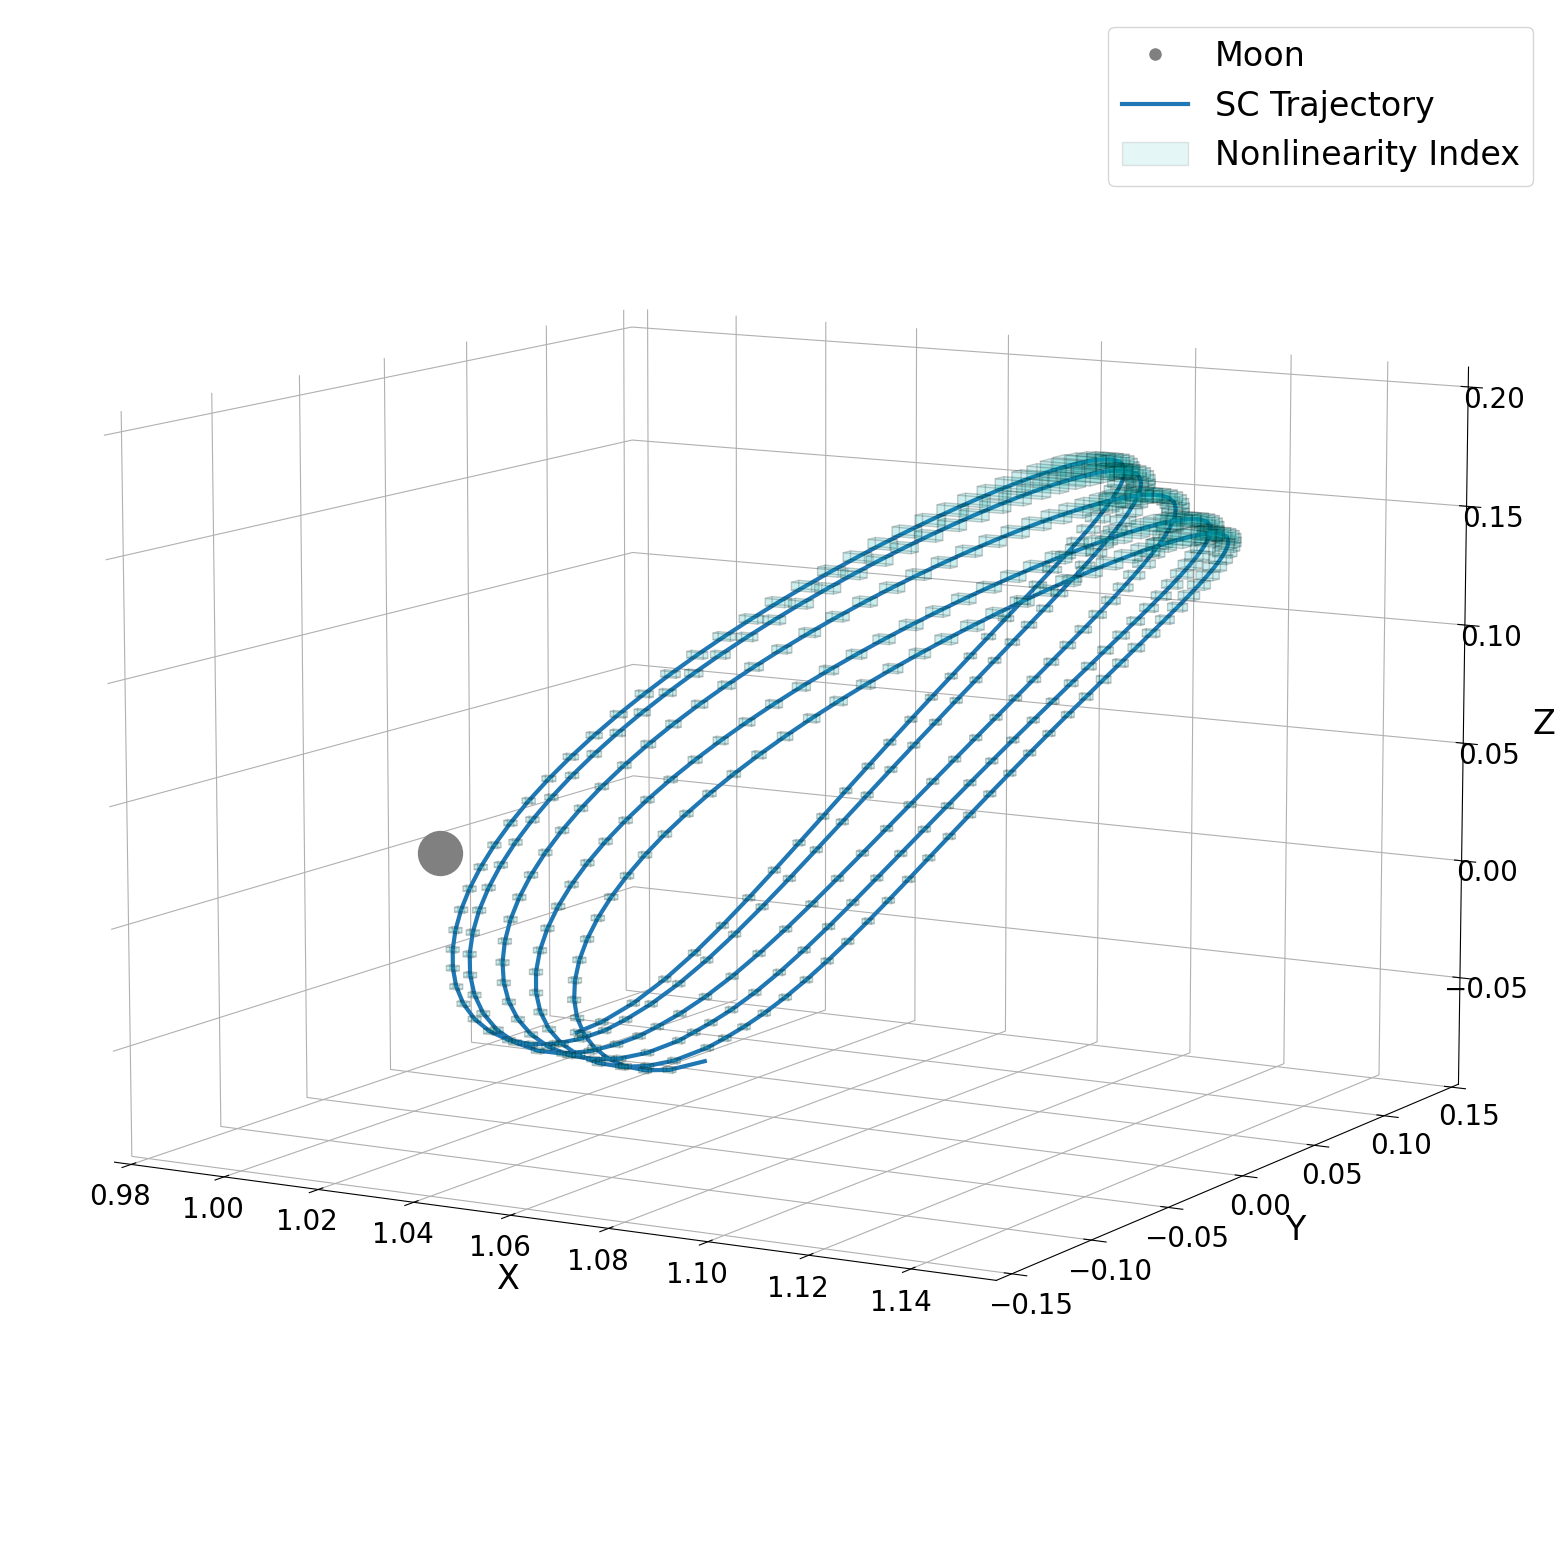

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

# Increase default font size
plt.rcParams.update({'font.size': 20})

# Constants
size_factor = 1e-2  # Adjust size of cubes

# Extract positions from trajectory
x_vals = program.x.value[:, 0]
y_vals = program.x.value[:, 1]
z_vals = program.x.value[:, 2]

# Extract cube sizes from nonlinearity index
if hasattr(program, 'mul_test') and program.mul_test is not None:
    cube_sizes = np.abs(program.mul_test[:, :3]) * size_factor
else:
    # Fallback: use a default size or compute from other attributes
    cube_sizes = np.ones((len(x_vals), 3)) * size_factor * 0.01

# Set up figure
fig = plt.figure(figsize=(20, 20))
fig.patch.set_facecolor('white')      # figure background
ax = fig.add_subplot(111, projection='3d')
ax.set_facecolor('white')             # axes background

# Make the 3D panes white
ax.xaxis.set_pane_color((1, 1, 1, 1))
ax.yaxis.set_pane_color((1, 1, 1, 1))
ax.zaxis.set_pane_color((1, 1, 1, 1))

# Plot the moon without legend label
ax.scatter(
    [1 - mu_val], [0], [0],
    c='gray', s=1e3,
    label='_nolegend_'
)

# Plot the trajectory and capture its handle
trajectory, = ax.plot(
    x_vals, y_vals, z_vals,
    label='SC Trajectory',
    linewidth=3
)

# Function to draw a cube at a given center with given half‑sizes
def draw_cube(ax, center, size):
    x, y, z = center
    dx, dy, dz = size
    vertices = np.array([
        [x - dx, y - dy, z - dz],
        [x + dx, y - dy, z - dz],
        [x + dx, y + dy, z - dz],
        [x - dx, y + dy, z - dz],
        [x - dx, y - dy, z + dz],
        [x + dx, y - dy, z + dz],
        [x + dx, y + dy, z + dz],
        [x - dx, y + dy, z + dz],
    ])
    faces = [
        [vertices[j] for j in [0, 1, 2, 3]],
        [vertices[j] for j in [4, 5, 6, 7]],
        [vertices[j] for j in [0, 1, 5, 4]],
        [vertices[j] for j in [2, 3, 7, 6]],
        [vertices[j] for j in [1, 2, 6, 5]],
        [vertices[j] for j in [0, 3, 7, 4]],
    ]
    ax.add_collection3d(
        Poly3DCollection(
            faces,
            alpha=0.1,
            facecolor='#00B0B0',
            edgecolor='k'
        )
    )

# Draw cubes along the trajectory
for i in range(len(x_vals) - 1):
    draw_cube(
        ax,
        (x_vals[i], y_vals[i], z_vals[i]),
        cube_sizes[i]
    )

# Create proxies for the legend
cube_proxy = Patch(
    facecolor='#00B0B0',
    edgecolor='k',
    alpha=0.1,
    label='Nonlinearity Index'
)
moon_proxy = Line2D(
    [0], [0],
    marker='o',
    color='gray',
    linestyle='',
    markersize=8,
    label='Moon'
)

# Draw the legend with larger text
ax.legend(
    handles=[moon_proxy, trajectory, cube_proxy],
    loc='best',
    fontsize=24
)

# Label axes with larger font and extra padding
ax.set_xlabel('X', fontsize=24, labelpad=15)
ax.set_ylabel('Y', fontsize=24, labelpad=15)
ax.set_zlabel('Z', fontsize=24, labelpad=15)

# Tick labels larger
ax.tick_params(axis='both', which='major', labelsize=20)

# View settings
ax.view_init(elev=10, azim=300)
plt.savefig('cr3bp_nonlinearity_idx.eps')
plt.show()

In [ ]:
converged = False
i = 0 
opt_s_flag = True

while not converged:
    converged = program.optimize()
    print(f'Iteration {i}, trust region mode: {opt_s_flag}')
    
    # Print trust region values
    if hasattr(program, 'trust_region'):
        print(f'Trust region: {program.trust_region[0]}')

    # Plot thrust profile
    if hasattr(program, 's') and program.s.value is not None:
        # Calculate time steps
        days = np.concatenate(([0], np.cumsum(program.s.value))) / (program.N - 1)
        
        # Calculate thrust values
        if hasattr(program, 'tau_len') and hasattr(program, 'z_p'):
            thrust_values = (program.tau_len.value * np.exp(program.z_p) / (TU**2) * LUm / 
                           np.concatenate([program.s.value, [program.s.value[-1]]]))
            
            plt.figure(figsize=(10, 6))
            plt.plot(days, thrust_values)
            plt.scatter(days, thrust_values, c='red', s=10)
            plt.xlabel('Day')
            plt.ylabel('Thrust')
            plt.title(f'Thrust Profile - Iteration {i}')
            plt.show()

    i += 1
    
    # Toggle optimization flag (if needed for alternating optimization strategy)
    # opt_s_flag = not opt_s_flag
    
    # Safety break to prevent infinite loops
    if i > 50:
        print("Maximum iterations reached")
        break

print(f'Completed in {i} iterations')

In [ ]:
# Check if s_p attribute exists, otherwise show available attributes
if hasattr(program, 's_p'):
    print("s_p values:", program.s_p)
elif hasattr(program, 's') and program.s.value is not None:
    print("s values:", program.s.value)
else:
    print("Available program attributes:")
    print([attr for attr in dir(program) if not attr.startswith('_')])

In [ ]:
fig = plt.figure(figsize=(20, 20))
ax = fig.add_subplot(111, projection='3d')

# Plot moon
ax.scatter([1 - mu_val], [0], [0], c='gray', s=1e3, label='Moon')

# Plot optimized trajectory
if hasattr(program, 'x') and program.x.value is not None:
    ax.plot(program.x.value[:, 0], program.x.value[:, 1], program.x.value[:, 2], 
            label='SC Trajectory', linewidth=3)
else:
    print("No trajectory data available")

ax.set_xlabel('X')
ax.set_ylabel('Y') 
ax.set_zlabel('Z')
ax.view_init(elev=10, azim=300)
ax.legend()
plt.show()

In [ ]:
# … (earlier code unchanged) …

# Draw the legend with larger text
ax.legend(
    handles=[moon_proxy, trajectory, cube_proxy],
    loc='best',
    fontsize=24
)

# Label axes with larger font and extra padding
ax.set_xlabel('X', fontsize=24, labelpad=20)
ax.set_ylabel('Y', fontsize=24, labelpad=20)
ax.set_zlabel('Z', fontsize=24, labelpad=20)

# Tick labels larger
ax.tick_params(axis='both', which='major', labelsize=20)

# View settings
ax.view_init(elev=10, azim=300)

plt.show()


In [ ]:
# Check for nonlinearity index
if hasattr(program, 'nonlinear') and program.nonlinear is not None:
    print("Minimum nonlinearity index:", program.nonlinear.min())
else:
    print("No nonlinearity index data available")
    print("Available attributes containing 'nonlinear':")
    nonlinear_attrs = [attr for attr in dir(program) if 'nonlinear' in attr.lower()]
    print(nonlinear_attrs)

np.float64(0.0049184954483491375)

In [ ]:
# Check for maximum inverse nonlinearity index
if hasattr(program, 'nonlinear') and program.nonlinear is not None:
    print("Maximum inverse nonlinearity index:", (1/program.nonlinear).max())
else:
    print("No nonlinearity index data available for inverse calculation")

np.float64(203.31420665147587)

In [ ]:
# Run single optimization step
result = program.optimize()
print("Optimization result:", result)

mul 0.5 20.0
0.005905982289662326 -2.279207858779664e-06


(np.False_, np.float64(0.06079775223723828), np.float64(0.06670601373475939))

In [ ]:
plt.figure(figsize=(20, 20))

if hasattr(program, 's') and program.s.value is not None:
    # Calculate time steps
    days = np.concatenate(([0], np.cumsum(program.s.value))) / (program.N - 1)
    
    # Calculate thrust values if attributes exist
    if hasattr(program, 'tau_len') and hasattr(program, 'z_p'):
        thrust_values = (program.tau_len.value * np.exp(program.z_p) / (TU**2) * LUm / 
                       np.concatenate([program.s.value, [program.s.value[-1]]]))
        
        plt.plot(days, thrust_values)
        plt.scatter(days, thrust_values, c='red', s=3)
        plt.xlabel('Day')
        plt.ylabel('Thrust')
        plt.title('Thrust Profile')
        plt.show()
    else:
        print("Thrust calculation attributes not available")
        print("Available attributes:", [attr for attr in dir(program) if not attr.startswith('_')])
else:
    print("No time discretization data available")

In [ ]:

# fig = plt.figure(figsize=(10, 10))
# ax = fig.add_subplot(111, projection='3d')

# ax.plot(init_traj[:, 0], init_traj[:, 1], init_traj[:, 2], label='Trajectory before LS (t_i)')
# ax.view_init(elev=10, azim=300)


In [ ]:
# Check final mass value
if hasattr(program, 'z') and program.z.value is not None:
    final_mass = np.exp(program.z.value[-1])
    print("Final mass:", final_mass)
elif hasattr(program, 'x') and program.x.value is not None:
    # If mass is in state vector (7th dimension)
    if program.x.value.shape[1] > 6:
        final_log_mass = program.x.value[-1, 6]
        final_mass = np.exp(final_log_mass)
        print("Final mass:", final_mass)
    else:
        print("Mass information not found in state vector")
else:
    print("No mass data available")

In [ ]:
# Check s values (time discretization)
if hasattr(program, 's') and program.s.value is not None:
    print("s values:")
    print(program.s.value)
else:
    print("No s values available")
    print("Time-related attributes:")
    time_attrs = [attr for attr in dir(program) if 's' in attr.lower() or 'time' in attr.lower()]
    print(time_attrs)